# Udacity Intro to Data Analysis Final Project

In [18]:
import pandas as pd
import numpy as np
from ggplot import *
from scipy import stats
import statsmodels.api as sm
import ml_support

In [19]:
df = pd.read_csv('improved-dataset/turnstile_weather_v2.csv')

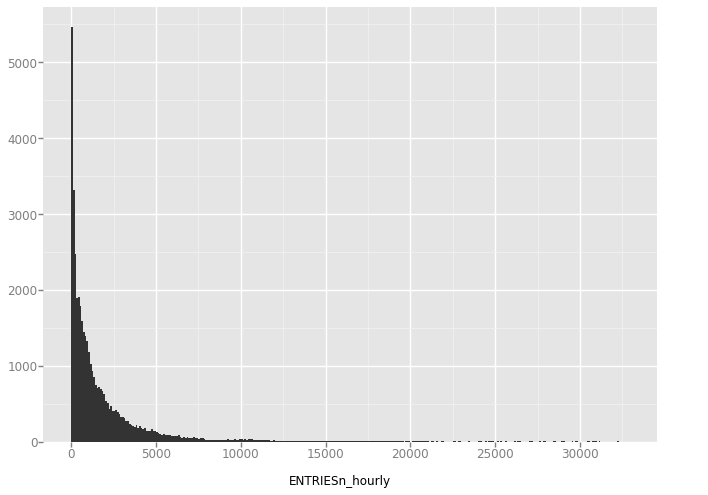

<ggplot: (279482646)>

In [3]:
ggplot(aes(x='ENTRIESn_hourly'), data=df) + geom_histogram(binwidth=100)

Histogram shows that ENTRIESn_hourly is positively skewed

In [4]:
stats.shapiro(df['ENTRIESn_hourly'].sample(5000))

(0.6090452075004578, 0.0)

Shapiro-Wilk test confirms that the distribution of ENTRIESn_hourly is not normal. 

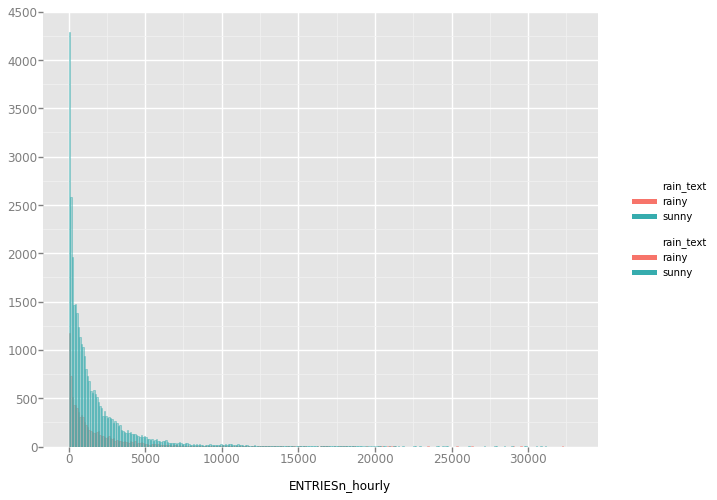

<ggplot: (283180713)>

In [5]:
df['rain_text'] = np.where(df['rain']==1, 'rainy', 'sunny')
ggplot(aes(x='ENTRIESn_hourly', fill='rain_text', color='rain_text'), data=df) +\
    geom_histogram(alpha=0.4, binwidth=100)

Distribution for rainy and sunny days are similarly skewed so we can do a Mann-Whitney test.

In [6]:
df_rain = df.loc[df['rain'] == 1]
df_sun = df.loc[df['rain'] == 0]
assert len(df) == len(df_sun) + len(df_rain)
stats.mannwhitneyu(df_rain['ENTRIESn_hourly'], df_sun['ENTRIESn_hourly'])

MannwhitneyuResult(statistic=153635120.5, pvalue=2.7410695712437496e-06)

In [7]:
df.groupby('rain', as_index=False)['ENTRIESn_hourly'].mean()

,rain,ENTRIESn_hourly
0,0,1845.539439
1,1,2028.196035


Based on the results of the Mann-Whitney U test, we can reject the null hypothesis that the probability is 50% that a randomly drawn member of the first population will exceed a member of the second population at alpha=0.05. Based on the means, it appears that subway ridership in our sample is higher on rainy days than on sunny days. 

In [8]:
features = df[['hour', 'weekday', 'rain', 'precipi',\
               'fog', 'wspdi', 'pressurei', 'tempi']]
features, mu, sigma = ml_support.normalize_features(features)
dummy_units = pd.get_dummies(df['UNIT'], prefix='UNIT')
features = features.join(dummy_units)
dummy_units = pd.get_dummies(df['conds'], prefix='conds')
features = features.join(dummy_units)
dummy_units = pd.get_dummies(df['day_week'], prefix='day_week')
features = features.join(dummy_units)
values = df['ENTRIESn_hourly']
X = np.array(features)
Y = np.array(values)

Creating features for machine learning. Included dummy features for unit (somewhat analogous to station but got better results than station, likely because units are opened and closed at different times of the day), weather conditions, and whether the day was a weekday or a weekend. 

In [9]:
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
prediction = results.predict(X) 

Ran OLS from Statsmodels on the data

In [10]:
ml_support.compute_r_squared(values, prediction)

0.4885061568506267

R2 = .49

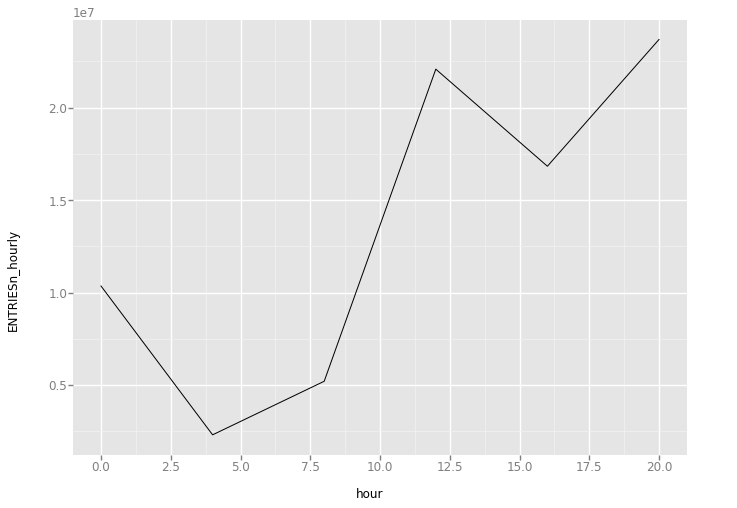

<ggplot: (-9223372036572759082)>

In [11]:
to_plot = df.groupby('hour', as_index=False).sum()
ggplot(aes(y='ENTRIESn_hourly', x='hour'), data=to_plot) + geom_line()

Graph of ridership by time of day

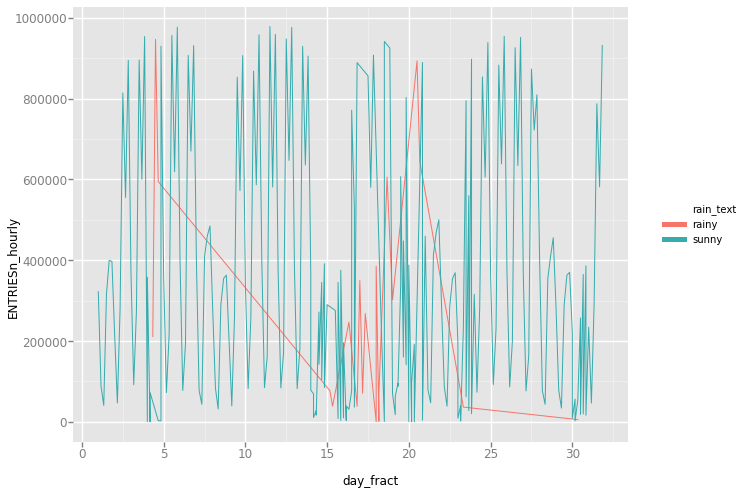

<ggplot: (287310561)>

In [13]:
df['day_fract'] = pd.to_datetime(df['datetime']).dt.day + df['hour'] / 24
to_plot = df.groupby(['day_fract', 'rain'], as_index=False).sum()
to_plot
to_plot['rain_text'] = np.where(to_plot['precipi']>0, 'rainy', 'sunny')
ggplot(aes(y='ENTRIESn_hourly', x='day_fract', color='rain_text'), data=to_plot) +\
    geom_line()

Based on the data, ridership is lower on the New York City Subway when it is raining than when it is not raining. 